In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.distributions.normal import Normal
import torch.optim as optim
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.nn import Parameter
from torch import nn
from torch.utils.data import Dataset, DataLoader

import scipy.stats
import time
import pickle
import os
import sys

In [2]:
!rm -r h-vae/

In [3]:
!git clone https://github.com/Daniil-Selikhanovych/h-vae

Cloning into 'h-vae'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 106 (delta 32), reused 97 (delta 26), pack-reused 0
Receiving objects: 100% (106/106), 400.62 KiB | 28.62 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [4]:
!pip install pyro-ppl

from pyro.nn import AutoRegressiveNN

     |████████████████████████████████| 614kB 10.9MB/s 


In [5]:
path_to_gaussians = os.path.join(os.getcwd(), 'h-vae', 'gaussians')
path_to_gaussians_api = os.path.join(path_to_gaussians, 'api')

sys.path.append(path_to_gaussians)
sys.path.append(path_to_gaussians_api)

In [6]:
from models import HVAE, NF, VB, IAF

In [7]:
class gaussian_dataset(Dataset):
    def __init__(self, x):
          'Initialization'
          self.x = x

    def __len__(self):
          'Denotes the total number of samples'
          return self.x.shape[0]

    def __getitem__(self, index):
          'Generates one sample of data'
          x_index = self.x[index]

          return x_index

In [14]:
def run_test(d, params, 
             clip_value=None,
             dtype=torch.float32, 
             device=torch.device("cpu")):
    """ 
    Run the gaussian test with dimension d 
    """

    ######### Problem Specification

    # Data generation parameters
    prior_mu_z = torch.zeros(d, dtype=dtype)    # Prior mean
    prior_sigma_z = torch.eye(d, dtype=dtype)   # Prior covariance matrix

    # True model parameters
    num_range = torch.arange(-(d-1)/2, (d+1)/2, dtype=dtype)

    t_delta =  num_range / 5 

    print(f"true delta = {t_delta.numpy()}")

    if d == 1:
        t_sigma = torch.ones(1, dtype=dtype)
    else: 
        # Allow sigma to range from 0.1 to 1
        t_sigma = 36/(10*(d-1)**2) * num_range**2 + 0.1 
    print(f"true sigma = {t_sigma.numpy()}")

    ######### Variable Initialization

    # Initial model parameters - same across all methods
    init_delta = prior_mu_z.clone().to(device)
    init_log_sigma = 3 * torch.ones(d).to(device)

    # Initial HVAE variational parameters
    init_T = torch.tensor(5., dtype=dtype, device=device)
    init_eps = 0.005 * torch.ones(d, dtype=dtype)
    max_eps = params['max_eps'] * torch.ones(d, dtype=dtype)
    init_logit_eps = torch.log(init_eps/(max_eps - init_eps)).to(device)
    init_log_T_0 = torch.log(init_T - 1)

    # Initial NF variational parameters
    init_u_pre_reparam = torch.tensor(scipy.stats.truncnorm.rvs(-2, 2, 
                                                                scale=0.1, 
                                                                size=d),
                                      dtype=dtype, device=device)
    init_w = torch.tensor(scipy.stats.truncnorm.rvs(-2, 2, scale=0.1, size=d),
                          dtype=dtype, device=device)
    init_b = torch.tensor(0.1, dtype=dtype, device=device)

    # Initial VAE parameters
    init_mu_z = prior_mu_z.clone()
    init_log_sigma_z = torch.ones(d, dtype=dtype)

    ######### Set up models
    init_params = [[init_delta, init_log_sigma, init_logit_eps, init_log_T_0],
                   [init_delta, init_log_sigma, init_logit_eps, init_log_T_0],
                   [init_delta, init_log_sigma, init_u_pre_reparam, init_w, init_b],
                   [init_delta, init_log_sigma, init_u_pre_reparam, init_w, init_b],
                   [init_delta, init_log_sigma, init_mu_z, init_log_sigma_z]]

    HVAE_model_1 = HVAE(params,
        ['delta', 'log_sigma', 'logit_eps', 'log_T_0'],
        init_params[0], 
        'HVAE_1', d, params['HVAE_K_1'])
    HVAE_model_2 = HVAE(params,
        ['delta', 'log_sigma', 'logit_eps', 'log_T_0'],
        init_params[1], 
        'HVAE_2', d, params['HVAE_K_2'])
    
    
    NF_model_1 = NF(params,
        ['delta', 'log_sigma', 'u_pre_reparam', 'w', 'b'],
        init_params[2],
        'NF_1', d, params['NF_K_1'])
    
    NF_model_2 = NF(params,
        ['delta', 'log_sigma', 'u_pre_reparam', 'w', 'b'],
        init_params[3],
        'NF_2', d, params['NF_K_2'])
    
    VB_model = VB(params,
        ['delta', 'log_sigma', 'mu_z', 'log_sigma_z'], 
        init_params[4], 'VB', d)

    #model_list = [HVAE_model_1, HVAE_model_2, NF_model_1]
    #model_list = [HVAE_model_1, NF_model_1]
    model_list = [HVAE_model_1, HVAE_model_2, NF_model_1, NF_model_2, VB_model]

    print("Models were initialized!")
    
    ######### Generate Training Data & Save - One for each test

    train_data_list = []

    for i in range(params['n_tests']):
        z = MultivariateNormal(prior_mu_z, prior_sigma_z).sample()
        x = MultivariateNormal(z + t_delta, 
                               torch.diag(t_sigma**2)).sample([params['n_data']])
        x = x.to(device)
        train_data_list.append(x)

    # Folder should have already been created in the initializations
    data_path = os.path.join('save', str(d), 'train_data.p')
    pickle.dump(train_data_list, open(data_path, 'wb')) 

    # Store the final parameter values for all test runs in this dictionary
    final_params = {}

    for i in range(len(model_list)):
        final_values = []
        m = model_list[i]
        model_init_params = init_params[i]

        for i in range(params['n_tests']):
            print("------------------------------------------------------")
            print(f"Test = {i}")
            print("------------------------------------------------------")
            m._reinitialize(model_init_params)
            (delta, sigma) = m.train(train_data_list[i], i, 
                                     t_delta, t_sigma,
                                     clip_value)
            final_values.append((delta, sigma))

        final_params[m.model_name] = final_values.copy()

    ######### Test models using difference between parameters

    param_diffs = {}

    for m in model_list:
        
        diffs = []

        for i in range(params['n_tests']):
            delta = final_params[m.model_name][i][0]
            sigma = final_params[m.model_name][i][1]

            delta_diff = np.sum((delta - t_delta.numpy())**2)
            sigma_diff = np.sum((sigma - t_sigma.numpy())**2)
            theta_diff = delta_diff + sigma_diff
            print(f"Model {m.model_name}, test = {i}, result delta diff = {delta_diff}")
            print(f"Model {m.model_name}, test = {i}, result sigma diff = {sigma_diff}")
            print(f"Model {m.model_name}, test = {i}, result theta diff = {theta_diff}")

            diffs.append((delta_diff, sigma_diff, theta_diff))

        param_diffs[m.model_name] = diffs.copy()

    # Save parameter differences in a pickle file
    diff_path = os.path.join('save', str(d), 'all_diffs.p')
    pickle.dump(param_diffs, open(diff_path, 'wb'))

In [15]:
params = {

    # PROBLEM SPECIFICATION
    #'dims': [1, 2, 3, 5, 11, 25, 51, 101, 201, 301], # Dimensions to test
    'dims': [2],
    'n_data': 10000,                                 # Number of data points

    # TEST HYPERPARAMETERS
    'n_tests': 10,      # Number of experiments to run

    # GLOBAL OPTIMIZATION PARAMETERS
    'n_iter': 30000,    # Number of optimization iterations
    'n_batch': 10,      # Number of points for ELBO estimate
    'rms_eta': 0.001,   # Stepsize for RMSProp
    'save_every': 50,   # Save parameter information every so often
    'print_every': 100, # Print less often than save

    # HVAE HYPERPARAMETERS
    'HVAE_K_1': 1,    # Number of leapfrog/cooling steps for HVAE flow 1
    'HVAE_K_2': 10,   # Number of leapfrog/cooling steps for HVAE flow 2
    'max_eps': 0.5,   # Maximum leapfrog step size per dimension 

    # NF HYPERPARAMETERS
    'NF_K_1': 1,    # Number of flow steps for NF flow 1
    'NF_K_2': 30,   # Number of flow steps for NF flow 2
    
}

In [16]:
device = torch.device("cuda")
dtype = torch.float32
clip_value = 1e-4

In [17]:
dims = params['dims']
seed = 12345
np.random.seed(seed)
torch.manual_seed(seed)
for d in dims:
    print('**** Running test for d={0:d} ****'.format(d))
    run_test(d, params, clip_value, dtype, device)

Выходные данные были обрезаны до нескольких последних строк (5000).
NF_2, d: 2, Iter: 8-27800, s/iter: 2.297e-02, ELBO: -3.732e+04
Cur diff delta = 1.0919286012649536
Cur diff sigma = 0.6522336602210999
Cur diff theta = 1.7441622614860535
---------------------------------------
log_det_sum = -4.508815288543701, y_sig_y = 8471.0341796875
mean_z_sig_z = 0.6631454825401306, mean_z_T_z = 1.8681100606918335
mean_y_bar_sig_z = 0.0002821453381329775
NF_2, d: 2, Iter: 8-27900, s/iter: 2.314e-02, ELBO: -3.878e+04
Cur diff delta = 1.1031314134597778
Cur diff sigma = 0.6302493214607239
Cur diff theta = 1.7333807349205017
---------------------------------------
log_det_sum = -4.7733917236328125, y_sig_y = 8420.80078125
mean_z_sig_z = 0.4373791217803955, mean_z_T_z = 1.2502120733261108
mean_y_bar_sig_z = -0.0010696210665628314
NF_2, d: 2, Iter: 8-28000, s/iter: 2.308e-02, ELBO: -3.769e+04
Cur diff delta = 1.1049898862838745
Cur diff sigma = 0.6478563547134399
Cur diff theta = 1.7528462409973145
---

NameError: ignored

In [378]:
dims = params['dims']
seed = 12345
np.random.seed(seed)
torch.manual_seed(seed)
for d in dims:
    print('**** Running test for d={0:d} ****'.format(d))
    run_test(d, params, clip_value, dtype, device)

**** Running test for d=2 ****
true delta = [-0.1  0.1]
true sigma = [1. 1.]
Models were initialized!
Init diff delta = 0.020000001415610313
Init diff sigma = 728.5154418945312
Init diff theta = 728.5354418959469
HVAE_1, d: 2, Iter: 1-100, s/iter: 2.196e-02, ELBO: -7.446e+04
Cur diff delta = 0.16634134948253632
Cur diff sigma = 474.51580810546875
Cur diff theta = 474.6821494549513
---------------------------------------
HVAE_1, d: 2, Iter: 1-200, s/iter: 2.160e-02, ELBO: -7.222e+04
Cur diff delta = 0.33115750551223755
Cur diff sigma = 371.67633056640625
Cur diff theta = 372.0074880719185
---------------------------------------
HVAE_1, d: 2, Iter: 1-300, s/iter: 2.180e-02, ELBO: -7.015e+04
Cur diff delta = 0.5265661478042603
Cur diff sigma = 296.72113037109375
Cur diff theta = 297.247696518898
---------------------------------------
HVAE_1, d: 2, Iter: 1-400, s/iter: 2.186e-02, ELBO: -6.819e+04
Cur diff delta = 0.7674179077148438
Cur diff sigma = 237.94444274902344
Cur diff theta = 238.

In [248]:
diff_path = os.path.join('save', str(params['dims'][0]), 'all_diffs.p')

In [249]:
with open(diff_path, 'rb') as f:
     data_new = pickle.load(f)
     print(data_new)

{'NF_1': [(0.064520195, 0.697576)]}


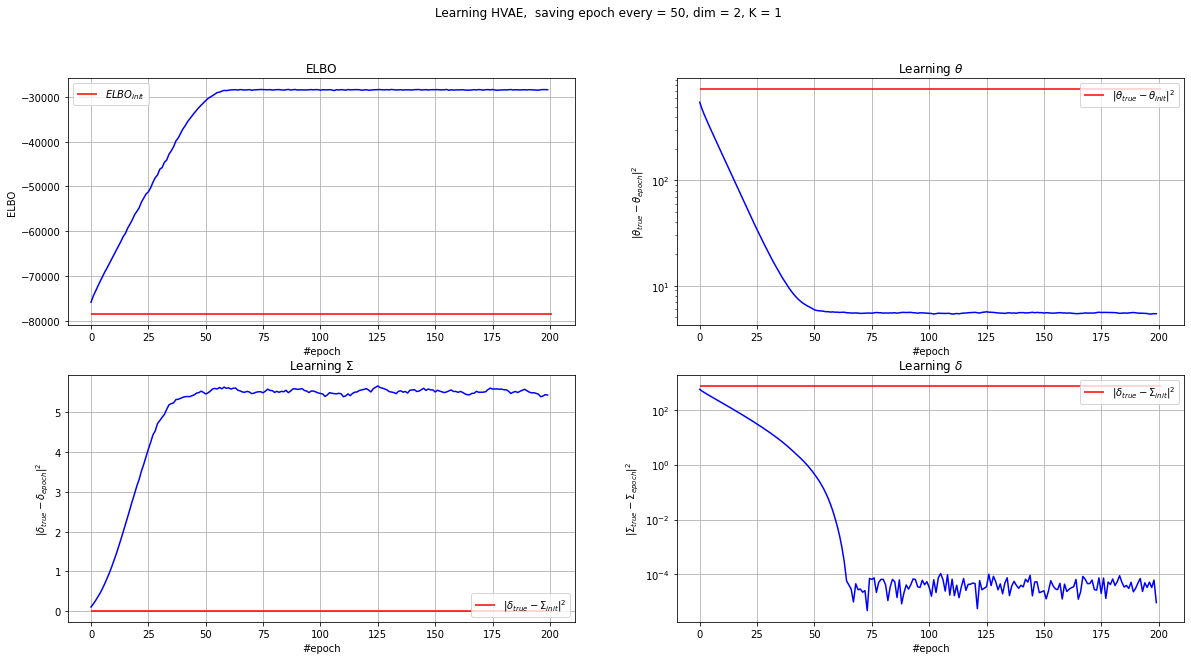

Init ELBO = -78496.1484375, result ELBO
Init diff theta = 728.5354614257812, result diff theta = 5.420054912567139
Init diff delta = 0.020000001415610313, result diff delta = 5.420045375823975
Init diff sigma = 728.5154418945312, result diff sigma = 9.466280971537344e-06


In [139]:
diff_path = os.path.join('save', str(params['dims'][0]), 'HVAE_1_train_0.p')
with open(diff_path, 'rb') as f:
     data = pickle.load(f)
     elbo = data['elbo']
     diff_delta = data['diff_delta']
     diff_sigma = data['diff_sigma']
     diff = data['diff']

fig, axs = plt.subplots(2, 2, figsize = (20, 10))
fig.suptitle(f"Learning HVAE,  saving epoch every = {params['save_every']}, dim = {2}, K = {params['HVAE_K_1']}")
axs[0, 0].set_xlabel("#epoch")
axs[0, 0].set_ylabel("ELBO")
axs[0, 1].set_xlabel("#epoch")
axs[0, 1].set_ylabel(r"$\|\theta_{true} - \theta_{epoch}\|^{2}$")
axs[1, 0].set_xlabel("#epoch")
axs[1, 0].set_ylabel("$\|\delta_{true} - \delta_{epoch}\|^{2}$")
axs[1, 1].set_xlabel("#epoch")
axs[1, 1].set_ylabel("$\|\Sigma_{true} - \Sigma_{epoch}\|^{2}$")
axs[0, 0].grid(True)
axs[0, 1].grid(True)
axs[1, 0].grid(True)
axs[1, 1].grid(True)
axs[0, 0].set_title('ELBO')
axs[0, 1].set_title(r'Learning $\theta$')
axs[1, 0].set_title(r'Learning $\Sigma$')
axs[1, 1].set_title(r'Learning $\delta$')
axs[0, 0].plot(elbo[1:], 'b')
axs[0, 1].plot(diff[1:], 'b')
axs[1, 0].plot(diff_delta[1:], 'b')
axs[1, 1].plot(diff_sigma[1:], 'b')
axs[0, 0].hlines(elbo[0], 0, len(elbo), 'r', label = r'$ELBO_{init}$')
axs[0, 1].hlines(diff[0], 0, len(diff), 'r', label = r'$\|\theta_{true} - \theta_{init}\|^{2}$')
axs[1, 0].hlines(diff_delta[0], 0, len(diff_delta), 'r', label = r'$\|\delta_{true} - \Sigma_{init}\|^{2}$')
axs[1, 1].hlines(diff_sigma[0], 0, len(diff_sigma), 'r', label = r'$\|\delta_{true} - \Sigma_{init}\|^{2}$')
axs[0, 0].legend()
axs[0, 1].legend()
axs[1, 0].legend()
axs[1, 1].legend()
axs[0, 1].set_yscale('log')
#axs[1, 0].set_yscale('log')
axs[1, 1].set_yscale('log')
plt.show()
print(f"Init ELBO = {elbo[0]}, result ELBO")
print(f"Init diff theta = {diff[0]}, result diff theta = {diff[-1]}")
print(f"Init diff delta = {diff_delta[0]}, result diff delta = {diff_delta[-1]}")
print(f"Init diff sigma = {diff_sigma[0]}, result diff sigma = {diff_sigma[-1]}")

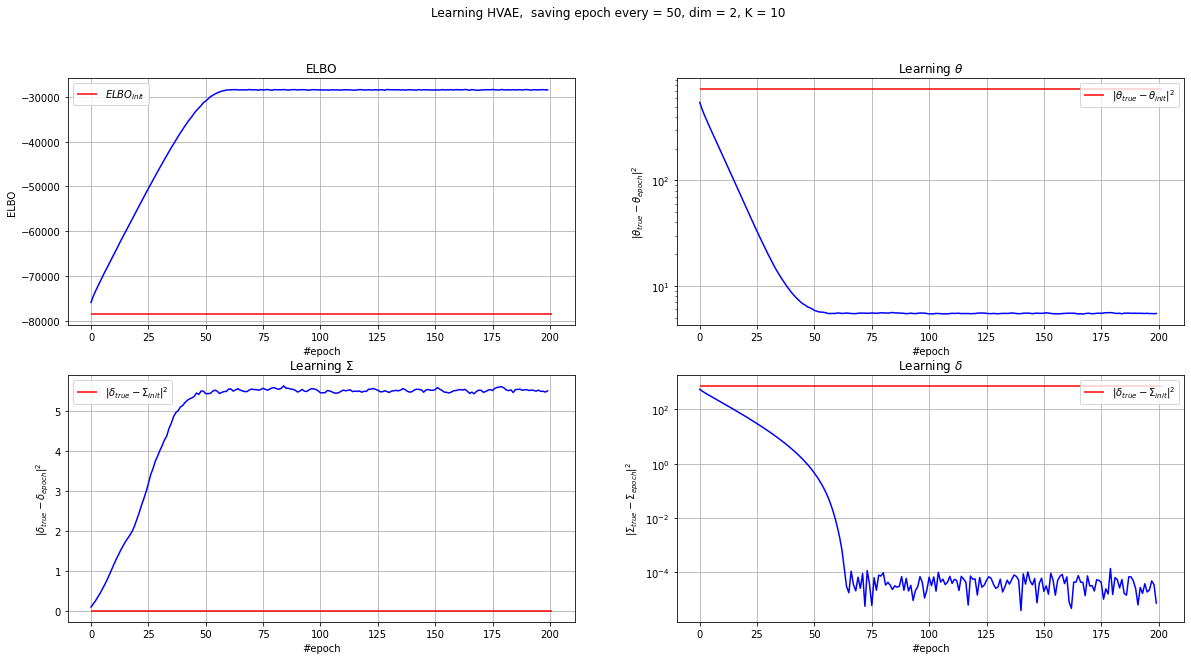

Init ELBO = -78482.6875, result ELBO
Init diff theta = 728.5354614257812, result diff theta = 5.496238708496094
Init diff delta = 0.020000001415610313, result diff delta = 5.496231555938721
Init diff sigma = 728.5154418945312, result diff sigma = 7.237440513563342e-06


In [140]:
diff_path = os.path.join('save', str(params['dims'][0]), 'HVAE_2_train_0.p')
with open(diff_path, 'rb') as f:
     data = pickle.load(f)
     elbo = data['elbo']
     diff_delta = data['diff_delta']
     diff_sigma = data['diff_sigma']
     diff = data['diff']

fig, axs = plt.subplots(2, 2, figsize = (20, 10))
fig.suptitle(f"Learning HVAE,  saving epoch every = {params['save_every']}, dim = {2}, K = {params['HVAE_K_2']}")
axs[0, 0].set_xlabel("#epoch")
axs[0, 0].set_ylabel("ELBO")
axs[0, 1].set_xlabel("#epoch")
axs[0, 1].set_ylabel(r"$\|\theta_{true} - \theta_{epoch}\|^{2}$")
axs[1, 0].set_xlabel("#epoch")
axs[1, 0].set_ylabel("$\|\delta_{true} - \delta_{epoch}\|^{2}$")
axs[1, 1].set_xlabel("#epoch")
axs[1, 1].set_ylabel("$\|\Sigma_{true} - \Sigma_{epoch}\|^{2}$")
axs[0, 0].grid(True)
axs[0, 1].grid(True)
axs[1, 0].grid(True)
axs[1, 1].grid(True)
axs[0, 0].set_title('ELBO')
axs[0, 1].set_title(r'Learning $\theta$')
axs[1, 0].set_title(r'Learning $\Sigma$')
axs[1, 1].set_title(r'Learning $\delta$')
axs[0, 0].plot(elbo[1:], 'b')
axs[0, 1].plot(diff[1:], 'b')
axs[1, 0].plot(diff_delta[1:], 'b')
axs[1, 1].plot(diff_sigma[1:], 'b')
axs[0, 0].hlines(elbo[0], 0, len(elbo), 'r', label = r'$ELBO_{init}$')
axs[0, 1].hlines(diff[0], 0, len(diff), 'r', label = r'$\|\theta_{true} - \theta_{init}\|^{2}$')
axs[1, 0].hlines(diff_delta[0], 0, len(diff_delta), 'r', label = r'$\|\delta_{true} - \Sigma_{init}\|^{2}$')
axs[1, 1].hlines(diff_sigma[0], 0, len(diff_sigma), 'r', label = r'$\|\delta_{true} - \Sigma_{init}\|^{2}$')
axs[0, 0].legend()
axs[0, 1].legend()
axs[1, 0].legend()
axs[1, 1].legend()
axs[0, 1].set_yscale('log')
#axs[1, 0].set_yscale('log')
axs[1, 1].set_yscale('log')
plt.show()
print(f"Init ELBO = {elbo[0]}, result ELBO")
print(f"Init diff theta = {diff[0]}, result diff theta = {diff[-1]}")
print(f"Init diff delta = {diff_delta[0]}, result diff delta = {diff_delta[-1]}")
print(f"Init diff sigma = {diff_sigma[0]}, result diff sigma = {diff_sigma[-1]}")

In [14]:
def run_test(d, params, 
             batch_size=256,
             clip_value=None,
             dtype=torch.float32, 
             device=torch.device("cpu")):
    """ 
    Run the gaussian test with dimension d 
    """

    ######### Problem Specification

    # Data generation parameters
    prior_mu_z = torch.zeros(d, dtype=dtype)    # Prior mean
    prior_sigma_z = torch.eye(d, dtype=dtype)   # Prior covariance matrix

    # True model parameters
    num_range = torch.arange(-(d-1)/2, (d+1)/2, dtype=dtype)

    t_delta =  num_range / 5 

    print(f"true delta = {t_delta.numpy()}")

    if d == 1:
        t_sigma = torch.ones(1, dtype=dtype)
    else: 
        # Allow sigma to range from 0.1 to 1
        t_sigma = 36/(10*(d-1)**2) * num_range**2 + 0.1 
    print(f"true sigma = {t_sigma.numpy()}")

    ######### Variable Initialization

    # Initial model parameters - same across all methods
    init_delta = prior_mu_z.clone().to(device)
    init_log_sigma = 3 * torch.ones(d).to(device)

    # Initial HVAE variational parameters
    init_T = torch.tensor(5., dtype=dtype, device=device)
    init_eps = 0.005 * torch.ones(d, dtype=dtype)
    max_eps = params['max_eps'] * torch.ones(d, dtype=dtype)
    init_logit_eps = torch.log(init_eps/(max_eps - init_eps)).to(device)
    init_log_T_0 = torch.log(init_T - 1)

    # Initial NF variational parameters
    init_u_pre_reparam = torch.tensor(scipy.stats.truncnorm.rvs(-2, 2, 
                                                                scale=0.1, 
                                                                size=d),
                                      dtype=dtype, device=device)
    init_w = torch.tensor(scipy.stats.truncnorm.rvs(-2, 2, scale=0.1, size=d),
                          dtype=dtype, device=device)
    init_b = torch.tensor(0.1, dtype=dtype, device=device)

    # Initial VAE parameters
    init_mu_z = prior_mu_z.clone()
    init_log_sigma_z = torch.ones(d, dtype=dtype)

    ######### Set up models
    init_params = [[init_delta, init_log_sigma, init_logit_eps, init_log_T_0],
                   [init_delta, init_log_sigma, init_logit_eps, init_log_T_0],
                   [init_delta, init_log_sigma, init_u_pre_reparam, init_w, init_b],
                   [init_delta, init_log_sigma, init_u_pre_reparam, init_w, init_b],
                   [init_delta, init_log_sigma, init_mu_z, init_log_sigma_z]]

    HVAE_model_1 = HVAE(params,
        ['delta', 'log_sigma', 'logit_eps', 'log_T_0'],
        init_params[0], 
        'HVAE_1', d, params['HVAE_K_1'])
    HVAE_model_2 = HVAE(params,
        ['delta', 'log_sigma', 'logit_eps', 'log_T_0'],
        init_params[1], 
        'HVAE_2', d, params['HVAE_K_2'])
    
    
    NF_model_1 = NF(params,
        ['delta', 'log_sigma', 'u_pre_reparam', 'w', 'b'],
        init_params[2],
        'NF_1', d, params['NF_K_1'])
    
    NF_model_2 = NF(params,
        ['delta', 'log_sigma', 'u_pre_reparam', 'w', 'b'],
        init_params[3],
        'NF_2', d, params['NF_K_2'])

    #model_list = [HVAE_model_1, HVAE_model_2, NF_model_1]
    #model_list = [HVAE_model_1, NF_model_1]
    model_list = [HVAE_model_1, HVAE_model_2, NF_model_1, NF_model_2]

    print("Models were initialized!")
    
    ######### Generate Training Data & Save - One for each test

    train_data_list = []

    for i in range(params['n_tests']):
        z = MultivariateNormal(prior_mu_z, prior_sigma_z).sample()
        x = MultivariateNormal(z + t_delta, 
                               torch.diag(t_sigma**2)).sample([params['n_data']])
        x = x.to(device)
        train_data_list.append(x)

    # Folder should have already been created in the initializations
    data_path = os.path.join('save', str(d), 'train_data.p')
    pickle.dump(train_data_list, open(data_path, 'wb')) 

    # Store the final parameter values for all test runs in this dictionary
    final_params = {}

    for i in range(len(model_list)):
        final_values = []
        m = model_list[i]
        model_init_params = init_params[i]

        for j in range(params['n_tests']):
            print("------------------------------------------------------")
            print(f"Test = {j}")
            print("------------------------------------------------------")
            m._reinitialize(model_init_params)
            gaussian_data = gaussian_dataset(train_data_list[j])
            train_dataloader = DataLoader(gaussian_data, batch_size=batch_size,
                                          shuffle=False, num_workers=0)
            (delta, sigma) = m.train(train_dataloader, j, 
                                     t_delta, t_sigma,
                                     clip_value)
            final_values.append((delta, sigma))

        final_params[m.model_name] = final_values.copy()

    ######### Test models using difference between parameters

    param_diffs = {}

    for m in model_list:
        
        diffs = []

        for i in range(params['n_tests']):
            delta = final_params[m.model_name][i][0]
            sigma = final_params[m.model_name][i][1]

            delta_diff = np.sum((delta - t_delta.numpy())**2)
            sigma_diff = np.sum((sigma - t_sigma.numpy())**2)
            theta_diff = delta_diff + sigma_diff
            print(f"Model {m.model_name}, test = {i}, result delta diff = {delta_diff}")
            print(f"Model {m.model_name}, test = {i}, result sigma diff = {sigma_diff}")
            print(f"Model {m.model_name}, test = {i}, result theta diff = {theta_diff}")

            diffs.append((delta_diff, sigma_diff, theta_diff))

        param_diffs[m.model_name] = diffs.copy()

    # Save parameter differences in a pickle file
    diff_path = os.path.join('save', str(d), 'all_diffs.p')
    pickle.dump(param_diffs, open(diff_path, 'wb'))

In [15]:
params = {

    # PROBLEM SPECIFICATION
    #'dims': [1, 2, 3, 5, 11, 25, 51, 101, 201, 301], # Dimensions to test
    'dims': [400],
    'n_data': 10000,                                 # Number of data points

    # TEST HYPERPARAMETERS
    'n_tests': 3,      # Number of experiments to run

    # GLOBAL OPTIMIZATION PARAMETERS
    'n_iter': 2000,    # Number of optimization iterations
    'n_batch': 10,      # Number of points for ELBO estimate
    'rms_eta': 0.001,   # Stepsize for RMSProp
    'save_every': 20,   # Save parameter information every so often
    'print_every': 20, # Print less often than save

    # HVAE HYPERPARAMETERS
    'HVAE_K_1': 1,    # Number of leapfrog/cooling steps for HVAE flow 1
    'HVAE_K_2': 10,   # Number of leapfrog/cooling steps for HVAE flow 2
    'max_eps': 0.5,   # Maximum leapfrog step size per dimension 

    # NF HYPERPARAMETERS
    'NF_K_1': 1,    # Number of flow steps for NF flow 1
    'NF_K_2': 30,   # Number of flow steps for NF flow 2
    
}

In [16]:
device = torch.device("cuda")
dtype = torch.float32
clip_value = None
batch_size = 256

In [17]:
dims = params['dims']
seed = 12345
np.random.seed(seed)
torch.manual_seed(seed)
for d in dims:
    print('**** Running test for d={0:d} ****'.format(d))
    run_test(d, params, batch_size, clip_value, dtype, device)

Выходные данные были обрезаны до нескольких последних строк (5000).
Cur diff delta = 51391.9140625
Cur diff sigma = 48225.65234375
Cur diff theta = 99617.56640625
---------------------------------------
HVAE_1, d: 400, Iter: 3-400, s/iter: 1.663e-01, ELBO: -8.323e+06
Cur diff delta = 46656.73046875
Cur diff sigma = 43629.85546875
Cur diff theta = 90286.5859375
---------------------------------------
HVAE_1, d: 400, Iter: 3-420, s/iter: 1.668e-01, ELBO: -7.984e+06
Cur diff delta = 42219.69140625
Cur diff sigma = 39337.0390625
Cur diff theta = 81556.73046875
---------------------------------------
HVAE_1, d: 400, Iter: 3-440, s/iter: 1.666e-01, ELBO: -7.619e+06
Cur diff delta = 38085.33984375
Cur diff sigma = 35399.59375
Cur diff theta = 73484.93359375
---------------------------------------
HVAE_1, d: 400, Iter: 3-460, s/iter: 1.656e-01, ELBO: -7.306e+06
Cur diff delta = 34219.96484375
Cur diff sigma = 31628.50390625
Cur diff theta = 65848.46875
---------------------------------------
H

In [18]:
model_names = ['HVAE_1', 'HVAE_2', 'NF_1', 'NF_2']
diff_delta_results = {}
diff_sigma_results = {}
diff_results = {}
for name in model_names:
    diff_delta_tests = np.zeros(params['n_tests'])
    diff_sigma_tests = np.zeros(params['n_tests'])
    diff_tests = np.zeros(params['n_tests'])
    for i in range(params['n_tests']):
        file_name = name + '_train_' + str(i) + '.p'
        diff_path = os.path.join('save', str(params['dims'][0]), file_name)
        with open(diff_path, 'rb') as f:
            data = pickle.load(f)
            elbo = data['elbo']
            diff_delta = data['diff_delta']
            diff_sigma = data['diff_sigma']
            diff = diff_delta + diff_sigma
            diff_delta_is_not_nan = diff_delta[~np.isnan(diff_delta)]
            diff_sigma_is_not_nan = diff_sigma[~np.isnan(diff_sigma)]
            diff_is_not_nan = diff[~np.isnan(diff)]
            diff_delta_tests[i] = diff_delta_is_not_nan[-1]
            diff_sigma_tests[i] = diff_sigma_is_not_nan[-1]
            diff_tests[i] = diff_is_not_nan[-1]
    diff_delta_results[name] = diff_delta_tests
    diff_sigma_results[name] = diff_sigma_tests
    diff_results[name] = diff_tests
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, diff delta = {diff_delta_tests}")
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, diff sigma = {diff_sigma_tests}")
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, diff = {diff_tests}")

Model = HVAE_1, dimensionality = 400, diff delta = [398.23248291 384.93457031 385.52194214]
Model = HVAE_1, dimensionality = 400, diff sigma = [0.60924375 0.60220844 0.60992485]
Model = HVAE_1, dimensionality = 400, diff = [398.84173584 385.53677368 386.13186646]
Model = HVAE_2, dimensionality = 400, diff delta = [397.94848633 384.43453979 387.17648315]
Model = HVAE_2, dimensionality = 400, diff sigma = [0.6068632  0.60265934 0.60724831]
Model = HVAE_2, dimensionality = 400, diff = [398.55535889 385.03720093 387.78372192]
Model = NF_1, dimensionality = 400, diff delta = [397.21939087 384.66744995 386.93475342]
Model = NF_1, dimensionality = 400, diff sigma = [252.05168152 251.83648682 252.45475769]
Model = NF_1, dimensionality = 400, diff = [649.27105713 636.50390625 639.38952637]
Model = NF_2, dimensionality = 400, diff delta = [396.97174072 384.64883423 386.35165405]
Model = NF_2, dimensionality = 400, diff sigma = [252.85713196 252.59661865 251.87812805]
Model = NF_2, dimensionality

In [19]:
for name in model_names:
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, mean diff delta = {diff_delta_results[name].mean()}")
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, mean diff sigma = {diff_sigma_results[name].mean()}")
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, mean diff = {diff_results[name].mean()}")

Model = HVAE_1, dimensionality = 400, mean diff delta = 389.56299845377606
Model = HVAE_1, dimensionality = 400, mean diff sigma = 0.6071256796518961
Model = HVAE_1, dimensionality = 400, mean diff = 390.1701253255208
Model = HVAE_2, dimensionality = 400, mean diff delta = 389.85316975911456
Model = HVAE_2, dimensionality = 400, mean diff sigma = 0.605590283870697
Model = HVAE_2, dimensionality = 400, mean diff = 390.45876057942706
Model = NF_1, dimensionality = 400, mean diff delta = 389.60719807942706
Model = NF_1, dimensionality = 400, mean diff sigma = 252.11430867513022
Model = NF_1, dimensionality = 400, mean diff = 641.7214965820312
Model = NF_2, dimensionality = 400, mean diff delta = 389.32407633463544
Model = NF_2, dimensionality = 400, mean diff sigma = 252.44395955403647
Model = NF_2, dimensionality = 400, mean diff = 641.7680460611979


In [ ]:
0.0052


In [ ]:
diff_path = os.path.join('save', str(params['dims'][0]), 'HVAE_1_train_0.p')
with open(diff_path, 'rb') as f:
     data = pickle.load(f)
     elbo_1 = data['elbo']
     diff_delta_1 = data['diff_delta']
     diff_sigma_1 = data['diff_sigma']
     diff_1 = diff_delta_1 + diff_sigma_1

diff_path = os.path.join('save', str(params['dims'][0]), 'HVAE_2_train_0.p')
with open(diff_path, 'rb') as f:
     data = pickle.load(f)
     elbo_2 = data['elbo']
     diff_delta_2 = data['diff_delta']
     diff_sigma_2 = data['diff_sigma']
     diff_2 = diff_delta_2 + diff_sigma_2

fig, axs = plt.subplots(2, 2, figsize = (20, 10))
fig.suptitle(f"Learning HVAE,  saving epoch every = {params['save_every']}, dim = {2}")
axs[0, 0].set_xlabel("#epoch")
axs[0, 0].set_ylabel("ELBO")
axs[0, 1].set_xlabel("#epoch")
axs[0, 1].set_ylabel(r"$\|\theta_{true} - \theta_{epoch}\|^{2}$")
axs[1, 0].set_xlabel("#epoch")
axs[1, 0].set_ylabel("$\|\delta_{true} - \delta_{epoch}\|^{2}$")
axs[1, 1].set_xlabel("#epoch")
axs[1, 1].set_ylabel("$\|\Sigma_{true} - \Sigma_{epoch}\|^{2}$")
axs[0, 0].grid(True)
axs[0, 1].grid(True)
axs[1, 0].grid(True)
axs[1, 1].grid(True)
axs[0, 0].set_title('ELBO')
axs[0, 1].set_title(r'Learning $\theta$')
axs[1, 0].set_title(r'Learning $\Sigma$')
axs[1, 1].set_title(r'Learning $\delta$')
axs[0, 0].plot(elbo_1[1:], 'b', label = f"K = {params['HVAE_K_1']}")
axs[0, 0].plot(elbo_2[1:], 'r', label = f"K = {params['HVAE_K_2']}")
axs[0, 1].plot(diff_1[1:], 'b', label = f"K = {params['HVAE_K_1']}")
axs[0, 1].plot(diff_2[1:], 'r', label = f"K = {params['HVAE_K_2']}")
axs[1, 0].plot(diff_delta_1[1:], 'b', label = f"K = {params['HVAE_K_1']}")
axs[1, 0].plot(diff_delta_2[1:], 'r', label = f"K = {params['HVAE_K_2']}")
axs[1, 1].plot(diff_sigma_1[1:], 'b', label = f"K = {params['HVAE_K_1']}")
axs[1, 1].plot(diff_sigma_2[1:], 'r', label = f"K = {params['HVAE_K_2']}")
axs[0, 0].hlines(elbo_1[0], 0, len(elbo_1), 'g', label = r'$ELBO_{init}$')
axs[0, 1].hlines(diff_1[0], 0, len(diff_1), 'g', label = r'$\|\theta_{true} - \theta_{init}\|^{2}$')
axs[1, 0].hlines(diff_delta_1[0], 0, len(diff_delta_1), 'g', label = r'$\|\delta_{true} - \delta_{init}\|^{2}$')
axs[1, 1].hlines(diff_sigma_1[0], 0, len(diff_sigma_1), 'g', label = r'$\|\Sigma_{true} - \Sigma_{init}\|^{2}$')
axs[0, 0].legend()
axs[0, 1].legend()
axs[1, 0].legend()
axs[1, 1].legend()
axs[0, 1].set_yscale('log')
#axs[1, 0].set_yscale('log')
axs[1, 1].set_yscale('log')
plt.show()
print(f"Init ELBO = {elbo_1[0]}, HVAE-1: result ELBO = {elbo_1[-1]}, HVAE-2: result ELBO = {elbo_2[-1]}")
print(f"Init diff theta = {diff_1[0]}, HVAE-1: result diff theta = {diff_1[-1]}, HVAE-2: result diff theta = {diff_2[-1]}")
print(f"Init diff delta = {diff_delta_1[0]}, HVAE-1: result diff delta = {diff_delta_1[-1]}, HVAE-2: result diff theta = {diff_delta_2[-1]}")
print(f"Init diff sigma = {diff_sigma_1[0]}, HVAE-1: result diff sigma = {diff_sigma_1[-1]}, HVAE-2: result diff theta = {diff_sigma_2[-1]}")

In [8]:
def run_test(d, params, 
             batch_size=256,
             clip_value=None,
             dtype=torch.float32, 
             device=torch.device("cpu")):
    """ 
    Run the gaussian test with dimension d 
    """

    ######### Problem Specification

    # Data generation parameters
    prior_mu_z = torch.zeros(d, dtype=dtype)    # Prior mean
    prior_sigma_z = torch.eye(d, dtype=dtype)   # Prior covariance matrix

    # True model parameters
    num_range = torch.arange(-(d-1)/2, (d+1)/2, dtype=dtype)

    t_delta =  num_range / 5 

    print(f"true delta = {t_delta.numpy()}")

    if d == 1:
        t_sigma = torch.ones(1, dtype=dtype)
    else: 
        # Allow sigma to range from 0.1 to 1
        t_sigma = 36/(10*(d-1)**2) * num_range**2 + 0.1 
    print(f"true sigma = {t_sigma.numpy()}")

    ######### Variable Initialization

    # Initial model parameters - same across all methods
    init_delta = prior_mu_z.clone().to(device)
    init_log_sigma = 3 * torch.ones(d).to(device)

    # Initial HVAE variational parameters
    init_T = torch.tensor(5., dtype=dtype, device=device)
    init_eps = 0.005 * torch.ones(d, dtype=dtype)
    max_eps = params['max_eps'] * torch.ones(d, dtype=dtype)
    init_logit_eps = torch.log(init_eps/(max_eps - init_eps)).to(device)
    init_log_T_0 = torch.log(init_T - 1)

    # Initial NF variational parameters
    init_u_pre_reparam = torch.tensor(scipy.stats.truncnorm.rvs(-2, 2, 
                                                                scale=0.1, 
                                                                size=d),
                                      dtype=dtype, device=device)
    init_w = torch.tensor(scipy.stats.truncnorm.rvs(-2, 2, scale=0.1, size=d),
                          dtype=dtype, device=device)
    init_b = torch.tensor(0.1, dtype=dtype, device=device)

    # Initial VAE parameters
    init_mu_z = prior_mu_z.clone()
    init_log_sigma_z = torch.ones(d, dtype=dtype)

    ######### Set up models
    init_params = [[init_delta, init_log_sigma],
                   [init_delta, init_log_sigma]]
    
    hid_dim = d + 100
    IAF_model = IAF(params,
        ['delta', 'log_sigma'],
        init_params[0], 
        'IAF', d, 1, hid_dim)

    #model_list = [HVAE_model_1, HVAE_model_2, NF_model_1]
    #model_list = [HVAE_model_1, NF_model_1]
    model_list = [IAF_model]

    print("Models were initialized!")
    
    ######### Generate Training Data & Save - One for each test

    train_data_list = []

    for i in range(params['n_tests']):
        z = MultivariateNormal(prior_mu_z, prior_sigma_z).sample()
        x = MultivariateNormal(z + t_delta, 
                               torch.diag(t_sigma**2)).sample([params['n_data']])
        x = x.to(device)
        train_data_list.append(x)

    # Folder should have already been created in the initializations
    data_path = os.path.join('save', str(d), 'train_data.p')
    pickle.dump(train_data_list, open(data_path, 'wb')) 

    # Store the final parameter values for all test runs in this dictionary
    final_params = {}

    for i in range(len(model_list)):
        final_values = []
        m = model_list[i]
        model_init_params = init_params[i]

        for j in range(params['n_tests']):
            print("------------------------------------------------------")
            print(f"Test = {j}")
            print("------------------------------------------------------")
            m._reinitialize(model_init_params)
            gaussian_data = gaussian_dataset(train_data_list[j])
            train_dataloader = DataLoader(gaussian_data, batch_size=batch_size,
                                          shuffle=False, num_workers=0)
            (delta, sigma) = m.train(train_dataloader, j, 
                                     t_delta, t_sigma,
                                     clip_value)
            final_values.append((delta, sigma))

        final_params[m.model_name] = final_values.copy()

    ######### Test models using difference between parameters

    param_diffs = {}

    for m in model_list:
        
        diffs = []

        for i in range(params['n_tests']):
            delta = final_params[m.model_name][i][0]
            sigma = final_params[m.model_name][i][1]

            delta_diff = np.sum((delta - t_delta.numpy())**2)
            sigma_diff = np.sum((sigma - t_sigma.numpy())**2)
            theta_diff = delta_diff + sigma_diff
            print(f"Model {m.model_name}, test = {i}, result delta diff = {delta_diff}")
            print(f"Model {m.model_name}, test = {i}, result sigma diff = {sigma_diff}")
            print(f"Model {m.model_name}, test = {i}, result theta diff = {theta_diff}")

            diffs.append((delta_diff, sigma_diff, theta_diff))

        param_diffs[m.model_name] = diffs.copy()

    # Save parameter differences in a pickle file
    diff_path = os.path.join('save', str(d), 'all_diffs.p')
    pickle.dump(param_diffs, open(diff_path, 'wb'))

In [9]:
device = torch.device("cpu")
dtype = torch.float32
clip_value = None
batch_size = 256

In [11]:
params = {

    # PROBLEM SPECIFICATION
    #'dims': [1, 2, 3, 5, 11, 25, 51, 101, 201, 301], # Dimensions to test
    'dims': [400],
    'n_data': 10000,                                 # Number of data points

    # TEST HYPERPARAMETERS
    'n_tests': 3,      # Number of experiments to run

    # GLOBAL OPTIMIZATION PARAMETERS
    'n_iter': 2000,    # Number of optimization iterations
    'n_batch': 10,      # Number of points for ELBO estimate
    'rms_eta': 0.001,   # Stepsize for RMSProp
    'save_every': 20,   # Save parameter information every so often
    'print_every': 20, # Print less often than save

    # HVAE HYPERPARAMETERS
    'HVAE_K_1': 1,    # Number of leapfrog/cooling steps for HVAE flow 1
    'HVAE_K_2': 10,   # Number of leapfrog/cooling steps for HVAE flow 2
    'max_eps': 0.5,   # Maximum leapfrog step size per dimension 

    # NF HYPERPARAMETERS
    'NF_K_1': 1,    # Number of flow steps for NF flow 1
    'NF_K_2': 30,   # Number of flow steps for NF flow 2
    
}

In [12]:
dims = params['dims']
seed = 12345
np.random.seed(seed)
torch.manual_seed(seed)
for d in dims:
    print('**** Running test for d={0:d} ****'.format(d))
    run_test(d, params, batch_size, clip_value, dtype, device)

**** Running test for d=400 ****
true delta = [-39.9 -39.7 -39.5 -39.3 -39.1 -38.9 -38.7 -38.5 -38.3 -38.1 -37.9 -37.7
 -37.5 -37.3 -37.1 -36.9 -36.7 -36.5 -36.3 -36.1 -35.9 -35.7 -35.5 -35.3
 -35.1 -34.9 -34.7 -34.5 -34.3 -34.1 -33.9 -33.7 -33.5 -33.3 -33.1 -32.9
 -32.7 -32.5 -32.3 -32.1 -31.9 -31.7 -31.5 -31.3 -31.1 -30.9 -30.7 -30.5
 -30.3 -30.1 -29.9 -29.7 -29.5 -29.3 -29.1 -28.9 -28.7 -28.5 -28.3 -28.1
 -27.9 -27.7 -27.5 -27.3 -27.1 -26.9 -26.7 -26.5 -26.3 -26.1 -25.9 -25.7
 -25.5 -25.3 -25.1 -24.9 -24.7 -24.5 -24.3 -24.1 -23.9 -23.7 -23.5 -23.3
 -23.1 -22.9 -22.7 -22.5 -22.3 -22.1 -21.9 -21.7 -21.5 -21.3 -21.1 -20.9
 -20.7 -20.5 -20.3 -20.1 -19.9 -19.7 -19.5 -19.3 -19.1 -18.9 -18.7 -18.5
 -18.3 -18.1 -17.9 -17.7 -17.5 -17.3 -17.1 -16.9 -16.7 -16.5 -16.3 -16.1
 -15.9 -15.7 -15.5 -15.3 -15.1 -14.9 -14.7 -14.5 -14.3 -14.1 -13.9 -13.7
 -13.5 -13.3 -13.1 -12.9 -12.7 -12.5 -12.3 -12.1 -11.9 -11.7 -11.5 -11.3
 -11.1 -10.9 -10.7 -10.5 -10.3 -10.1  -9.9  -9.7  -9.5  -9.3  -9.1  -8.9
  -8.

In [13]:
model_names = ['IAF']
diff_delta_results = {}
diff_sigma_results = {}
diff_results = {}
for name in model_names:
    diff_delta_tests = np.zeros(params['n_tests'])
    diff_sigma_tests = np.zeros(params['n_tests'])
    diff_tests = np.zeros(params['n_tests'])
    for i in range(params['n_tests']):
        file_name = name + '_train_' + str(i) + '.p'
        diff_path = os.path.join('save', str(params['dims'][0]), file_name)
        with open(diff_path, 'rb') as f:
            data = pickle.load(f)
            elbo = data['elbo']
            diff_delta = data['diff_delta']
            diff_sigma = data['diff_sigma']
            diff = diff_delta + diff_sigma
            diff_delta_is_not_nan = diff_delta[~np.isnan(diff_delta)]
            diff_sigma_is_not_nan = diff_sigma[~np.isnan(diff_sigma)]
            diff_is_not_nan = diff[~np.isnan(diff)]
            diff_delta_tests[i] = diff_delta_is_not_nan[-1]
            diff_sigma_tests[i] = diff_sigma_is_not_nan[-1]
            diff_tests[i] = diff_is_not_nan[-1]
    diff_delta_results[name] = diff_delta_tests
    diff_sigma_results[name] = diff_sigma_tests
    diff_results[name] = diff_tests
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, diff delta = {diff_delta_tests}")
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, diff sigma = {diff_sigma_tests}")
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, diff = {diff_tests}")

Model = IAF, dimensionality = 400, diff delta = [380.0793457  404.72677612 349.24490356]
Model = IAF, dimensionality = 400, diff sigma = [16.34070015 16.32381439 16.31697083]
Model = IAF, dimensionality = 400, diff = [396.42004395 421.05059814 365.56188965]


In [14]:
for name in model_names:
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, mean diff delta = {diff_delta_results[name].mean()}")
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, mean diff sigma = {diff_sigma_results[name].mean()}")
    print(f"Model = {name}, dimensionality = {params['dims'][0]}, mean diff = {diff_results[name].mean()}")

Model = IAF, dimensionality = 400, mean diff delta = 378.0170084635417
Model = IAF, dimensionality = 400, mean diff sigma = 16.32716178894043
Model = IAF, dimensionality = 400, mean diff = 394.34417724609375
